## Description:

    Diversity estimates on samples merged by PlantxFert

    Work in progress, using relative abundance errors is throwing an error in alpha diversity metric.
    

In [1]:

%load_ext rpy2.ipython

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(lme4)
library(lmerTest)
library(MuMIn)

# Loading phyloseq object

In [20]:
%%R
F = file.path('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds')
physeq.Full = readRDS(F)

#rarefy to standard depth
set.seed(45)
phy.r = rarefy_even_depth(physeq.Full) %>%
        subset_samples(SeedTreatment != "Untreated" & TimePoint != "T0" & Plant != "Bare")


phy.r

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [21]:
%%R
# add interaction of genotype and sampling date term for merge
sd = sample_data(phy.r)
sd = mutate(sd, TxGxF = paste(TimePoint, R_Year, Fert, sep = "_"))
rownames(sd) = sd$X.sampleID
sample_data(phy.r) = sd


In [22]:
%%R
# save TxG, R_Year and Sampling date lookup table

Y.df = sd %>%
    select(TxGxF, R_Year, TimePoint, Fert) %>%
    unique
colnames(Y.df) = c("Sample", "R_Year", "TimePoint", "Fert")
head(Y.df)


                     Sample R_Year TimePoint Fert
ERA-T2_3-1d_85   T2_2001_85   2001        T2   85
ERA-T1_3-5c_170 T1_1939_170   1939        T1  170
ERA-T1_1-4b_0     T1_2001_0   2001        T1    0
ERA-T1_1-4a_170 T1_1953_170   1953        T1  170
ERA-T3_1-3c_170 T3_1971_170   1971        T3  170
ERA-T1_4-4a_170 T1_1984_170   1984        T1  170


In [23]:
%%R
dim(Y.df)

[1] 48  4


In [35]:
%%R
m.phy = merge_samples(phy.r, "TxGxF")  %>%

    transform_sample_counts(function(x) x/sum(x))
        
m.phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [25]:
%%R
sample_sums(m.phy) %>% min

[1] 1


### set ggplot theme

In [26]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }


In [36]:
%%R
sample_data(m.phy)$TxGxF = rownames(sample_data(m.phy))

In [37]:
%%R
# add planted variable

sd = sample_data(m.phy) %>%
    select(-R_Year, -TimePoint, -Fert)
sd = left_join(sd, Y.df, by = c("TxGxF" = "Sample"))
head(sd)
# sd = mutate(sd, Planted = ifelse(Genotype == "Bare" | TimePoint == "T0", "Bare", "Rhizosphere"))
# rownames(sd) = sd$X.sampleID
# sd %>% head
# sample_data(phy.r) = sd

  X.sampleID TubeID ExtractionPlate PooledDNAPlate Sample.Well.ID PrimerPlate
1      36.25  37.50               3           1.50          51.50        1.50
2      37.25  37.25               3           1.50          37.50        1.50
3      38.25  37.00               3           2.25          18.00        2.25
4      37.75  38.75               3           1.50          25.25        1.50
5      38.75  39.25               3           1.50          53.50        1.50
6      39.75  38.25               3           1.50          51.75        1.50
  Primer.Number Primer.Well.ID  X primerFwdLoc primerRevLoc fwd_barcode
1         48.50          51.50 NA         8.50        15.50        8.50
2         37.50          37.50 NA         7.50        13.50       11.75
3         36.25          19.75 NA        12.25        18.00        5.00
4         50.50          25.25 NA         6.50        13.25        8.00
5         44.75          53.50 NA         8.75        15.00        9.25
6         48.75       

# Alpha Diversity

In [39]:
# %%R -w 800 -h 350
# alpha_meas = c("Observed", "Chao1", "Shannon", "Simpson")
# (p <- plot_richness(m.phy, "Planted", measures=alpha_meas))

# Alpha diversity variation among plants

In [41]:
%%R

#sample_data(phy.p)$Fert = as.factor(sample_data(phy.p))
alpha_meas = c("Observed", "Chao1", "Shannon", "Simpson")
p = plot_richness(phy.p, measures=alpha_meas)

p$data$Fert = as.factor(p$data$Fert)


Error in estimateR.default(newX[, i], ...) : 
  function accepts only integers (counts)


* Center year for interpretation

In [146]:
%%R
p$data$R_Year.c = p$data$R_Year - 1935

## alpha  T1

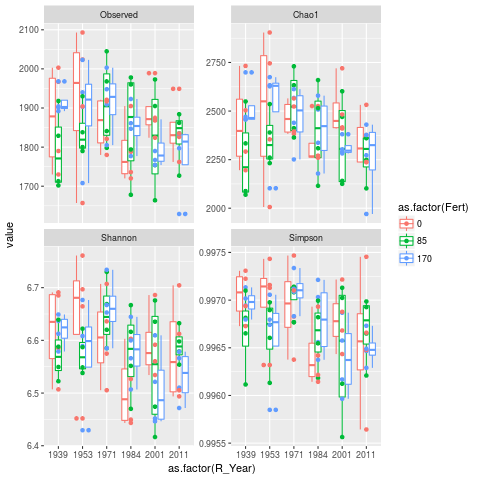

In [147]:
%%R
p.T1 = p$data %>% filter(TimePoint == "T1") 
ggplot(p.T1, aes(x = as.factor(R_Year), y = value, color = as.factor(Fert))) +
geom_boxplot() +
geom_point()+
facet_wrap(~variable, ncol = 2, scales = "free_y")

In [149]:
%%R
#test library effects on microbial diversity
tmp = p.T1 %>% filter(variable == "Chao1")

fit1 = lmer(value~ Fert*R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
              Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
Fert          133583   66791     2    63  2.3063 0.10799  
R_Year.c      120485  120485     1    63  4.1603 0.04558 *
Fert:R_Year.c 108502   54251     2    63  1.8733 0.16208  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
      R2m       R2c 
0.0969982 0.3264166 
$Rep
  (Intercept)    Fert85  Fert170   R_Year.c Fert85:R_Year.c Fert170:R_Year.c
1    2481.763 -105.6627 97.06495 -0.9652977       0.8145171         -2.77248
2    2594.172 -105.6627 97.06495 -0.9652977       0.8145171         -2.77248
3    2381.489 -105.6627 97.06495 -0.9652977       0.8145171         -2.77248
4    2424.705 -105.6627 97.06495 -0.9652977       0.8145171         -2.77248

attr(,"class")
[1] "coef.mer"
                       2.5 %      97.5 %
.sig01             35.276506  224.183686
.sigma            139.701623  195.721932
(Intercept)  

In [161]:
%%R
#test library effects on microbial diversity
tmp = p.T1 %>% filter(variable == "Shannon")

fit1 = lmer(value~ Fert*R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                 Sum Sq   Mean Sq NumDF DenDF F.value  Pr(>F)  
Fert          0.0073106 0.0036553     2    63  0.6421 0.52961  
R_Year.c      0.0281986 0.0281986     1    63  4.9531 0.02963 *
Fert:R_Year.c 0.0123565 0.0061782     2    63  1.0852 0.34406  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
       R2m        R2c 
0.08243873 0.21169660 
$Rep
  (Intercept)      Fert85     Fert170      R_Year.c Fert85:R_Year.c
1    6.619983 -0.03551568 0.009480007 -0.0008608854    0.0007482001
2    6.664653 -0.03551568 0.009480007 -0.0008608854    0.0007482001
3    6.616708 -0.03551568 0.009480007 -0.0008608854    0.0007482001
4    6.604188 -0.03551568 0.009480007 -0.0008608854    0.0007482001
  Fert170:R_Year.c
1    -0.0005137358
2    -0.0005137358
3    -0.0005137358
4    -0.0005137358

attr(,"class")
[1] "coef.mer"
                         2.5 %       97.5 %
.sig01            

## alpha at T2

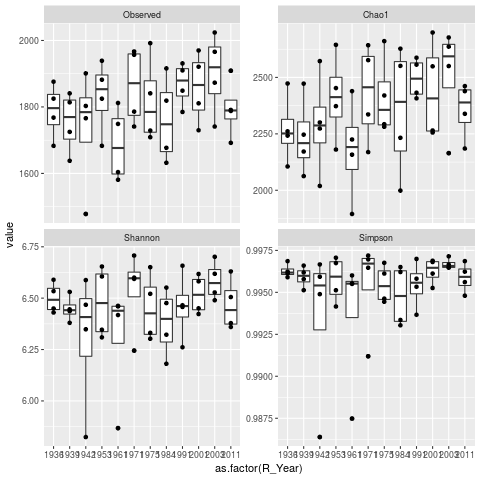

In [151]:
%%R
p.T2 = p$data %>% filter(TimePoint == "T2") 
ggplot(p.T2, aes(x = as.factor(R_Year), y = value)) +
geom_boxplot() +
geom_point()+
facet_wrap(~variable, ncol = 2, scales = "free_y")

In [162]:
%%R
#test library effects on microbial diversity
tmp = p.T2 %>% filter(variable == "Chao1")

fit1 = lmer(value~ R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
         Sum Sq Mean Sq NumDF DenDF F.value   Pr(>F)   
R_Year.c 203006  203006     1    43   8.643 0.005265 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
       R2m        R2c 
0.09517898 0.48242656 
$Rep
  (Intercept) R_Year.c
1    2325.718  2.58343
2    2418.449  2.58343
3    2142.994  2.58343
4    2191.479  2.58343

attr(,"class")
[1] "coef.mer"
                   2.5 %      97.5 %
.sig01        52.4508954  293.563471
.sigma       124.6218201  189.649846
(Intercept) 2107.4768361 2431.842879
R_Year.c       0.8429543    4.323906


* There was an increase in estimated richness (Chao1) with year of release, but overall model explained low portion of variance

In [163]:
%%R
#test library effects on microbial diversity
tmp = p.T2 %>% filter(variable == "Shannon")

fit1 = lmer(value~ R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
           Sum Sq  Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.c 0.050134 0.050134     1    43  1.8037 0.1863
       R2m        R2c 
0.03167658 0.17458348 
$Rep
  (Intercept)    R_Year.c
1    6.399800 0.001283827
2    6.486998 0.001283827
3    6.376476 0.001283827
4    6.358287 0.001283827

attr(,"class")
[1] "coef.mer"
                    2.5 %      97.5 %
.sig01       0.0000000000 0.172900696
.sigma       0.1355676254 0.206307158
(Intercept)  6.2956049220 6.515175185
R_Year.c    -0.0006095182 0.003177173


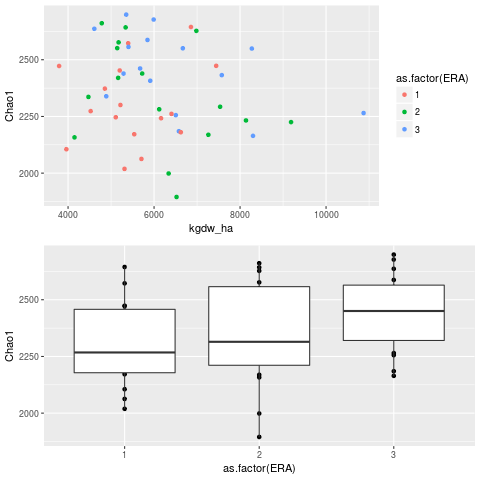

In [48]:
%%R
p1 = ggplot(tmp, aes(x = kgdw_ha, y = value, color = as.factor(ERA)))+
geom_point() +
ylab("Chao1") 

p2 = ggplot(tmp, aes(x = as.factor(ERA), y = value))+
geom_point() +
geom_boxplot() +
ylab("Chao1")

grid.arrange(p1, p2, ncol = 1)


## alpha at T3

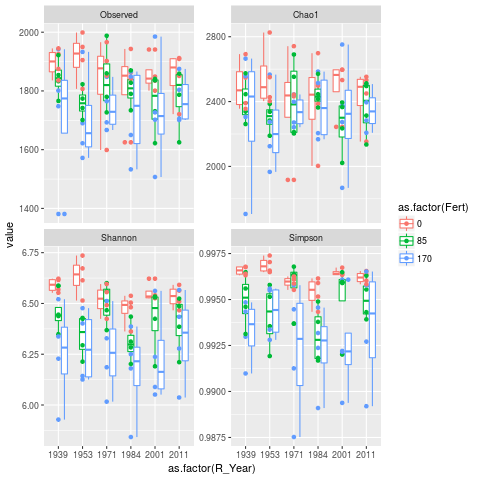

In [155]:
%%R
p.T3 = p$data %>% filter(TimePoint == "T3") 
ggplot(p.T3, aes(x = as.factor(R_Year), y = value, color = as.factor(Fert))) +
geom_boxplot() +
geom_point()+
facet_wrap(~variable, ncol = 2, scales = "free_y")

In [165]:
%%R
#test library effects on microbial diversity
tmp = p.T3 %>% filter(variable == "Chao1")

fit1 = lmer(value~ Fert*R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
              Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
Fert          160072   80036     2    63 2.08382 0.1329
R_Year.c        2693    2693     1    63 0.07011 0.7920
Fert:R_Year.c  34429   17214     2    63 0.44819 0.6408
      R2m       R2c 
0.0758244 0.2483215 
$Rep
  (Intercept)    Fert85  Fert170  R_Year.c Fert85:R_Year.c Fert170:R_Year.c
1    2494.830 -111.9486 -221.983 -1.068942       0.4601861          2.02098
2    2618.410 -111.9486 -221.983 -1.068942       0.4601861          2.02098
3    2419.130 -111.9486 -221.983 -1.068942       0.4601861          2.02098
4    2473.372 -111.9486 -221.983 -1.068942       0.4601861          2.02098

attr(,"class")
[1] "coef.mer"
                       2.5 %      97.5 %
.sig01             24.178820  217.726891
.sigma            160.882403  225.396200
(Intercept)      2331.380504 2671.491282
Fert85           -320.017019   96.119884
Fert170        

In [166]:
%%R
#test library effects on microbial diversity
tmp = p.T3 %>% filter(variable == "Shannon")

fit1 = lmer(value~ Fert*R_Year.c + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print
coef(fit1) %>% print
confint(fit1) %>% print

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq  Mean Sq NumDF DenDF F.value    Pr(>F)    
Fert          0.39600 0.198001     2    63  9.1164 0.0003332 ***
R_Year.c      0.00885 0.008849     1    63  0.4074 0.5255877    
Fert:R_Year.c 0.01335 0.006673     2    63  0.3072 0.7365741    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
      R2m       R2c 
0.4085021 0.4085021 
$Rep
  (Intercept)     Fert85    Fert170     R_Year.c Fert85:R_Year.c
1    6.596975 -0.1787401 -0.3491204 -0.001139055    0.0007923376
2    6.596975 -0.1787401 -0.3491204 -0.001139055    0.0007923376
3    6.596975 -0.1787401 -0.3491204 -0.001139055    0.0007923376
4    6.596975 -0.1787401 -0.3491204 -0.001139055    0.0007923376
  Fert170:R_Year.c
1      0.001309389
2      0.001309389
3      0.001309389
4      0.001309389

attr(,"class")
[1] "coef.mer"
                        2.5 %       97.5 %
.sig01            0.000000000  0.0

* R_Year seems to havea  significant effect on observed and estimated richness, but not diversity measures
* Should check other timepoints and fert effects next
* Check to see if richness or eveness is correlated with growth characteristic


# Graph alpha patterns

In [101]:
%%R
head(p$data)

       X.sampleID TubeID ExtractionPlate PooledDNAPlate Sample.Well.ID
1  ERA-T2_3-1d_85    425            ERA4              B             E5
2 ERA-T1_3-5c_170    213            ERA4              B             D3
3 ERA-T1_1-2b_170    125            ERA1              A             A1
4   ERA-T1_1-4b_0    144            ERA1              A             C4
5 ERA-T1_1-4a_170    141            ERA1              A             C2
6 ERA-T3_1-3c_170    566            ERA1              A             D4
  PrimerPlate Primer.Number Primer.Well.ID  X primerFwdLoc primerRevLoc
1           2            37             E5 NA          2-E          2-5
2           2            20             D3 NA          2-D          2-3
3           1             1             A1 NA          1-A          1-1
4           1            27             C4 NA          1-C          1-4
5           1            11             C2 NA          1-C          1-2
6           1            28             D4 NA          1-D          1-4

In [117]:
%%R
Time = c("T1", "T2", "T3")
Stage = c("V6", "R1", "R3")
dS = cbind(Time, Stage) %>% as.data.frame()
df = p$data %>%
    group_by(Genotype, Fert, R_Year, TimePoint, variable) %>%
    summarize(mValue = mean(value),
             seValue = sd(value)/sqrt(length(value)))  
df = left_join(df, dS, by = c("TimePoint" = "Time"))
df$Stage = factor(df$Stage, levels = c("V6", "R1", "R3"))
head(df)

Source: local data frame [6 x 8]
Groups: Genotype, Fert, R_Year, TimePoint [2]

  Genotype  Fert R_Year TimePoint variable       mValue      seValue  Stage
    <fctr> <int>  <int>    <fctr>   <fctr>        <dbl>        <dbl> <fctr>
1      322    85   1936        T2 Observed 1788.0000000 4.137028e+01     R1
2      322    85   1936        T2    Chao1 2270.5319714 7.591765e+01     R1
3      322    85   1936        T2  Shannon    6.5007564 3.716764e-02     R1
4      322    85   1936        T2  Simpson    0.9962788 2.057297e-04     R1
5      330     0   1939        T1 Observed 1872.5000000 6.650376e+01     V6
6      330     0   1939        T1    Chao1 2430.8549462 1.193803e+02     V6


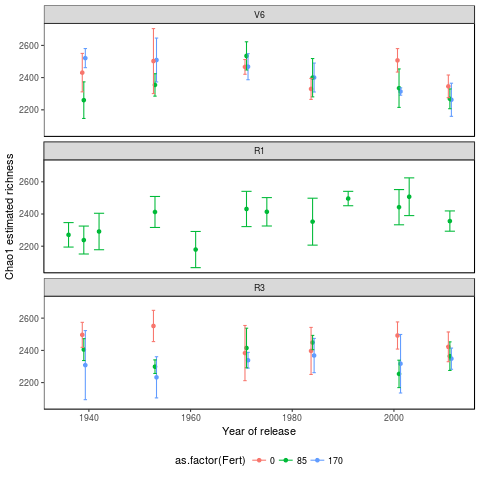

In [118]:
%%R

tmp = df %>% filter(variable == "Chao1") 
pC = ggplot(tmp, aes(x = R_Year, y = mValue, color = as.factor(Fert))) +
geom_point(position=position_dodge(width=0.9))+
geom_errorbar(aes(ymin = mValue - seValue, ymax = mValue + seValue), width = 2, position=position_dodge(width=0.9))+
theme_pub() +
facet_wrap(~Stage, ncol = 1)+
xlab("Year of release") +
ylab("Chao1 estimated richness") +
theme(legend.position = "bottom")
pC

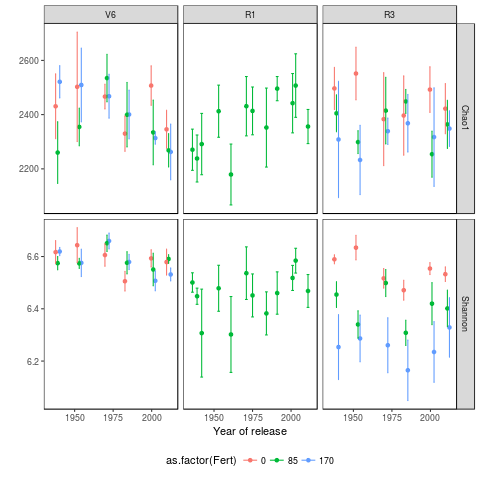

In [129]:
%%R

 tmp = df %>% filter(variable %in% c("Chao1", "Shannon")) 
pS = ggplot(tmp, aes(x = R_Year, y = mValue, color = as.factor(Fert))) +
geom_point(position=position_dodge(width=4))+
geom_errorbar(aes(ymin = mValue - seValue, ymax = mValue + seValue), position=position_dodge(width=4))+
theme_pub() +
facet_grid(variable~Stage, scales = "free_y")+
xlab("Year of release") +
ylab("")+
theme(legend.position = "bottom")
pS

# alpha diversity in seed treatments

In [198]:
%%R
phy.st = subset_samples(phy.r, Genotype %in% c("322", "3475", "34N42", "354") & TimePoint == "T2")
phy.st

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4597 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 34 sample variables ]
tax_table()   Taxonomy Table:    [ 4597 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4597 tips and 4596 internal nodes ]


In [199]:
%%R
alpha_meas = c("Observed", "Chao1", "Shannon", "Simpson")
p = plot_richness(phy.st, measures=alpha_meas)

p$data$Fert = as.factor(p$data$Fert)
p$data$R_Year.c = p$data$R_Year - 1935

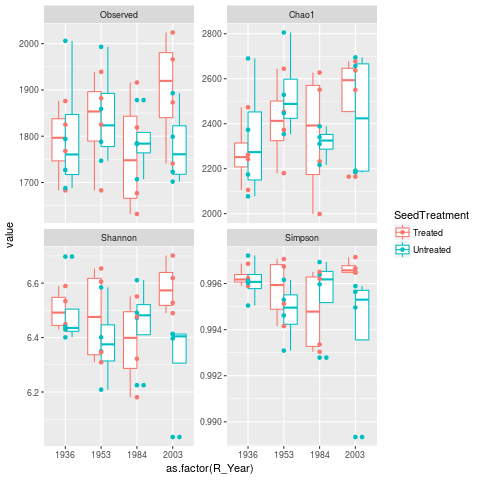

In [176]:
%%R

ggplot(p$data, aes(x = as.factor(R_Year), y = value, color = SeedTreatment)) +
geom_boxplot() +
geom_point()+
facet_wrap(~variable, ncol = 2, scales = "free_y")

In [183]:
%%R
#test library effects on microbial diversity
tmp = p$data %>% filter(variable == "Chao1")

fit1 = lmer(value~ Genotype*SeedTreatment + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print


Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                       Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
Genotype               196520   65507     3    21 2.94645 0.05643 .
SeedTreatment            2126    2126     1    21 0.09563 0.76019  
Genotype:SeedTreatment  48453   16151     3    21 0.72646 0.54756  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
      R2m       R2c 
0.1386885 0.6131717 


In [186]:
%%R
#test library effects on microbial diversity
tmp = p$data %>% filter(variable == "Chao1")

fit1 = lmer(value~ R_Year*SeedTreatment + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                     Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
R_Year                35869   35869     1    25  1.4012 0.2477
SeedTreatment         36261   36261     1    25  1.4165 0.2452
R_Year:SeedTreatment  36035   36035     1    25  1.4077 0.2466
       R2m        R2c 
0.04354907 0.53318643 


* among the plants sampled in treated and untreated plots, there was no effect of seed treatment on Chao1 and no interaction between year of release and chao1
* There was also no interaction between genotype and seed treatment.  
* The positive trend was less evident in the untreated batch, 

In [187]:
%%R
#test library effects on microbial diversity
tmp = p$data %>% filter(variable == "Shannon")

fit1 = lmer(value~ Genotype*SeedTreatment + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print


Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                         Sum Sq  Mean Sq NumDF DenDF F.value Pr(>F)
Genotype               0.028907 0.009636     3    21  0.5125 0.6781
SeedTreatment          0.046196 0.046196     1    21  2.4570 0.1319
Genotype:SeedTreatment 0.126113 0.042038     3    21  2.2359 0.1139
      R2m       R2c 
0.2269201 0.3426992 


In [188]:
%%R
#test library effects on microbial diversity
tmp = p$data %>% filter(variable == "Shannon")

fit1 = lmer(value~ R_Year.c*SeedTreatment + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print

r.squaredGLMM(fit1) %>% print

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                          Sum Sq   Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.c               0.0092985 0.0092985     1    25  0.4554 0.5060
SeedTreatment          0.0000450 0.0000450     1    25  0.0022 0.9629
R_Year.c:SeedTreatment 0.0300965 0.0300965     1    25  1.4740 0.2361
      R2m       R2c 
0.1050251 0.2233130 


*Similarly there was not an effect of seed treatment on Shannon's H and no interaction between seed treatment and year of release, or seed treatment and genotype.

## Graph seed treatments

In [197]:
%%R
head(p$data)

Source: local data frame [6 x 8]
Groups: Genotype, Fert, R_Year, TimePoint [3]

  Genotype   Fert R_Year TimePoint variable      mValue     seValue Stage
    <fctr> <fctr>  <int>    <fctr>   <fctr>       <dbl>       <dbl> <chr>
1      322     85   1936        T2    Chao1 2299.601108 72.67746406    R1
2      322     85   1936        T2  Shannon    6.496529  0.03628327    R1
3     3475     85   1984        T2    Chao1 2333.094263 69.86645130    R1
4     3475     85   1984        T2  Shannon    6.416202  0.05499397    R1
5    34N42     85   2003        T2    Chao1 2469.333361 86.13739419    R1
6    34N42     85   2003        T2  Shannon    6.449385  0.07037531    R1


In [200]:
%%R

df = p$data %>%
    group_by(Genotype, Fert, R_Year, TimePoint, SeedTreatment, variable) %>%
    summarize(mValue = mean(value),
             seValue = sd(value)/sqrt(length(value)))  %>%
    mutate(Stage = "R1")


head(df)

Source: local data frame [6 x 9]
Groups: Genotype, Fert, R_Year, TimePoint, SeedTreatment [2]

  Genotype   Fert R_Year TimePoint SeedTreatment variable       mValue
    <fctr> <fctr>  <int>    <fctr>        <fctr>   <fctr>        <dbl>
1      322     85   1936        T2       Treated Observed 1788.0000000
2      322     85   1936        T2       Treated    Chao1 2270.5319714
3      322     85   1936        T2       Treated  Shannon    6.5007564
4      322     85   1936        T2       Treated  Simpson    0.9962788
5      322     85   1936        T2     Untreated Observed 1803.7500000
6      322     85   1936        T2     Untreated    Chao1 2328.6702437
# ... with 2 more variables: seValue <dbl>, Stage <chr>


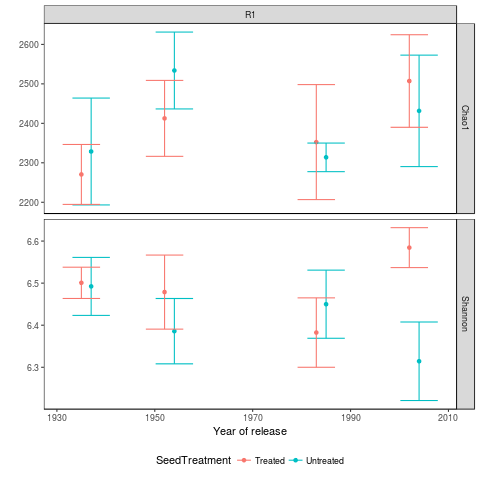

In [201]:
%%R
## Graph seed treatments

tmp = df %>% filter(variable %in% c("Chao1", "Shannon")) 
p = ggplot(tmp, aes(x = R_Year, y = mValue, color = SeedTreatment)) +
geom_point(position=position_dodge(width=4))+
geom_errorbar(aes(ymin = mValue - seValue, ymax = mValue + seValue), position=position_dodge(width=4))+
theme_pub() +
facet_grid(variable~Stage, scales = "free_y")+
xlab("Year of release") +
ylab("")+
theme(legend.position = "bottom")
p


In [ ]:

tmp = df %>% filter(variable %in% c("Chao1", "Shannon")) 
pS = ggplot(tmp, aes(x = R_Year, y = mValue, color = as.factor(Fert))) +
geom_point(position=position_dodge(width=4))+
geom_errorbar(aes(ymin = mValue - seValue, ymax = mValue + seValue), position=position_dodge(width=4))+
theme_pub() +
facet_grid(variable~Stage, scales = "free_y")+
xlab("Year of release") +
ylab("")+
theme(legend.position = "bottom")
pS